In [1]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# import necessary libraries

import os
import tensorflow as tf
import numpy as np

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import glob

In [7]:
# unzip Dataset

from zipfile import ZipFile
file_name='dataset.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


## Split Data Into Train Val & Test Folders

In [8]:
dataset = "dataset"
output = "out"

In [9]:
import splitfolders  # or import split_folders

# Split with a ratio. (80% training, 10% val, 10% test)
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(dataset, output=output, seed=1337, ratio=(.8, .1, .1), group_prefix=None) # default values

# Split val/test with a fixed number of items e.g. 100 for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
splitfolders.fixed(dataset, output=output, seed=1337, fixed=(100, 100), oversample=False, group_prefix=None) # default values



Copying files: 0 files [00:00, ? files/s]

Copying files: 383 files [00:00, 3825.84 files/s]

Copying files: 803 files [00:00, 4039.94 files/s]

Copying files: 1207 files [00:00, 3875.61 files/s]

Copying files: 1608 files [00:00, 3922.36 files/s]

Copying files: 2043 files [00:00, 3865.81 files/s]


Copying files: 0 files [00:00, ? files/s]

Copying files: 185 files [00:00, 1847.96 files/s]

Copying files: 370 files [00:00, 511.25 files/s] 

Copying files: 467 files [00:01, 347.34 files/s]

Copying files: 529 files [00:01, 322.05 files/s]

Copying files: 577 files [00:01, 318.69 files/s]

Copying files: 619 files [00:01, 288.25 files/s]

Copying files: 657 files [00:01, 291.02 files/s]

Copying files: 690 files [00:02, 272.11 files/s]

Copying files: 732 files [00:02, 298.37 files/s]

Copying files: 768 files [00:02, 300.34 files/s]

Copying files: 802 files [00:02, 292.00 files/s]

Copying files: 846 files [00:02, 289.73 files/s]

Copying files: 883 files [00:02, 299.44 files/s]

C

ValueError: The number of samples in class ".ipynb_checkpoints" are too few. There are only 0 samples available but your fixed parameter (100, 100) requires at least 200 files. You may want to split your classes by ratio.

## Data Visualization

In [10]:
train_dir = './out/train'
test_dir = './out/test'
val_dir = './out/val'

In [11]:
PET_train_images = glob.glob(train_dir+"/1-PET/*.jpg")

HDPE_train_images = glob.glob(train_dir+"/2-HDPE/*.JPG")
HDPE_train_images1 = glob.glob(train_dir+"/2-HDPE/*.jpg")

HDPE_concat_train_images = HDPE_train_images + HDPE_train_images1




Copying files: 2043 files [00:22, 1782.02 files/s]

In [12]:
a = len(HDPE_concat_train_images)
b = len(PET_train_images)
print(a)
print(b)
print("Total Train Images: ",a + b)

828
814
Total Train Images:  1642


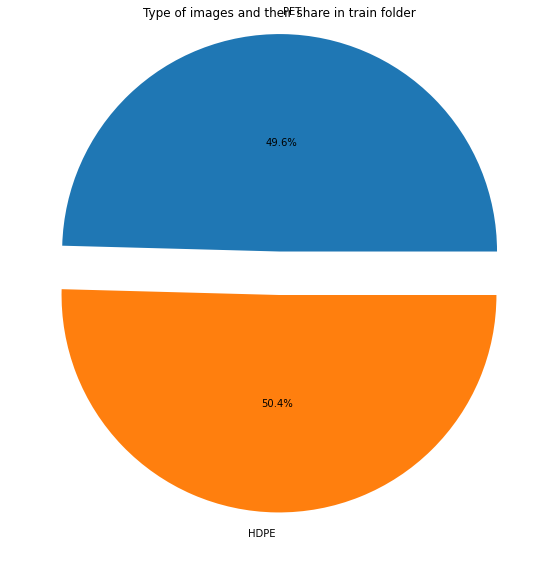

In [13]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([len(PET_train_images), len(HDPE_concat_train_images)]), autopct="%.1f%%", explode=[0.2,0], labels=["PET", "HDPE"], pctdistance=0.5)
plt.title("Type of images and their share in train folder", fontsize=12);

Copying files: 2043 files [12:07,  2.81 files/s] 
Copying files: 2043 files [13:32,  2.51 files/s]


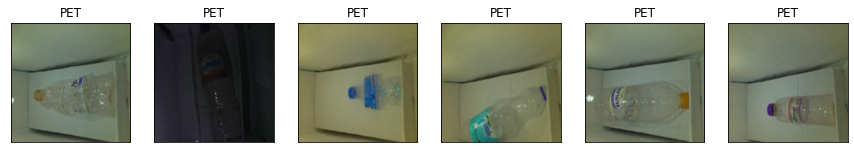

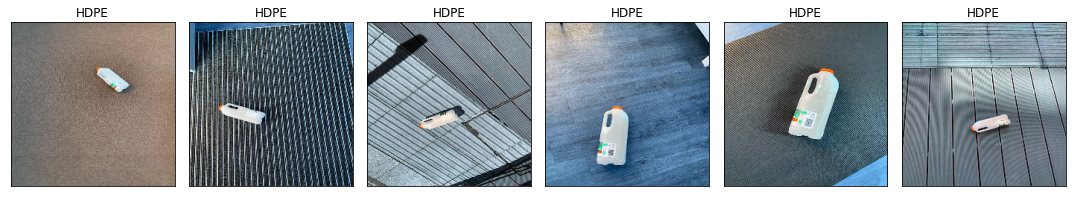

In [14]:
# e see that we have an imbalanced dataset. Hence, we will be using image augmentation techniques to compensate for this.

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(PET_train_images[i])
    img = cv2.resize(img, (512,512))
    ax.imshow(img)
    ax.set_title("PET")
    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(HDPE_concat_train_images[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.set_title("HDPE")
fig.tight_layout()    
plt.show()

## Data Augmenatation

In [15]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='binary', target_size = (220, 220))
validation_generator = val_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'binary', target_size=(220, 220))


Found 1643 images belonging to 3 classes.
Found 206 images belonging to 3 classes.


In [16]:
train_generator.class_indices

{'.ipynb_checkpoints': 0, '1-PET': 1, '2-HDPE': 2}

## Upload Data In s3

In [17]:
import sagemaker
sess = sagemaker.Session()
role = sagemaker.get_execution_role()

# prefix = 'snapCycle-classification'
# training_input_path   = sess.upload_data('./out/train', key_prefix=prefix+'/training')
# validation_input_path = sess.upload_data('./out/val', key_prefix=prefix+'/validation')

In [18]:
training_input_path = 's3://sagemaker-us-east-1-811710284692/snapCycle-classification/training'
validation_input_path = 's3://sagemaker-us-east-1-811710284692/snapCycle-classification/validation'
print(training_input_path)
print(validation_input_path)

s3://sagemaker-us-east-1-811710284692/snapCycle-classification/training
s3://sagemaker-us-east-1-811710284692/snapCycle-classification/validation


## Start Training job

In [21]:
from sagemaker.tensorflow import TensorFlow
from keras.preprocessing import image
import time
# install dependecies in tensorflow container.
env = {
    'SAGEMAKER_REQUIREMENTS': 'requirements.txt', # path relative to `source_dir` below.
}

#hyperperameter tuining
hyperparameters={'epochs': 2,
                 'batch-size': 20} 

tf_estimator = TensorFlow(entry_point='train.py',
                          source_dir='src',
                          role=role,
                          instance_count=1, 
                          instance_type='ml.m5.xlarge',     # $0.922 per hours
                          framework_version='2.3', 
                          py_version='py37',
                          script_mode=True,
                          hyperparameters = hyperparameters)

In [22]:
tf_estimator.hyperparameters()

{'epochs': '2', 'batch-size': '20', 'model_dir': 'null'}

In [23]:
tf_estimator.fit({'training':training_input_path, 'validation':validation_input_path})

2022-10-18 09:09:46 Starting - Starting the training job...
2022-10-18 09:10:14 Starting - Preparing the instances for trainingProfilerReport-1666084186: InProgress
.........
2022-10-18 09:11:34 Downloading - Downloading input data......
2022-10-18 09:12:35 Training - Training image download completed. Training in progress.2022-10-18 09:12:34.730069: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-10-18 09:12:34.735318: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-10-18 09:12:34.962323: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-10-18 09:12:38,336 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2022-10-18 09:12:38,344 sagemaker-training-toolkit INFO     No GPUs detected (norma

## Deploy Model

In [24]:
%%time
tf_endpoint_name = 'snapCycle-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

#tf_predictor = tf_estimator.deploy(initial_instance_count=1,
#                                   instance_type='ml.p2.xlarge')      # $1.361/hour 

tf_predictor = tf_estimator.deploy(initial_instance_count=1,
                                   instance_type='ml.t2.medium',        # $0.115/hour 
                                   endpoint_name=tf_endpoint_name) 

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------!CPU times: user 137 ms, sys: 6.24 ms, total: 144 ms
Wall time: 3min 31s


## Prediction

{'1-PET': 0, '2-HDPE': 1}

In [98]:
from keras.preprocessing import image
path_HDPE='out/test/2-HDPE/HDPEM669.JPG'
path_pet='out/test/1-PET/0217024149.jpg'

In [99]:
# img=image.load_img(path_pet, target_size=(220, 220))
img=image.load_img(path_HDPE, target_size=(220, 220))
x = np.asarray(img) / 255
x=np.expand_dims(x, axis=0)
images = np.vstack([x])

In [100]:
predictions2 =tf_predictor.predict(x)
# new_list = list(predictions2.values())
# new_list = np.array(new_list)
print(predictions2['predictions'][0])
if predictions2['predictions'][0][0]<0.5:
    print(path + " is a PET")
else:
    print(path + " is a HDPE")
# predicted_label = new_list.argmax(axis=1)
# print('Predicted labels are: {}'.format(predicted_label))

[1.0]
out/test/2-HDPE/HDPEM669.JPG is a HDPE


In [87]:
predictions2

{'predictions': [[1.0]]}

## Delete Endpoint